![banner](banner.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Primero cargamos la base de datos
with open ('mnist.txt') as f:
    lines = f.read()
    numbers_str = lines.split()


In [3]:
pixel_dataset = []
label_dataset = []
for i in range(0, 1000):
    pixel_dataset.append(np.array(numbers_str[((784*i)+i):((784*(i+1))+i)], dtype=int))
    label_dataset.append(np.array(numbers_str[((784*(i+1))+i)], dtype=int))
for i in range(len(pixel_dataset)):
    pixel_dataset[i] = pixel_dataset[i].reshape(28, 28)

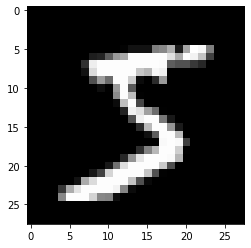

5


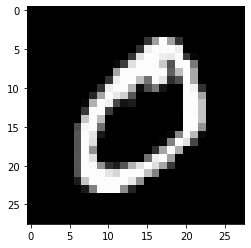

0


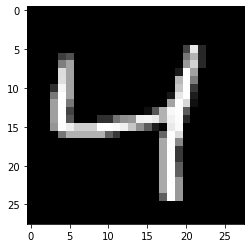

4


In [4]:
for i in range(3):
    plt.imshow(pixel_dataset[i], cmap='gray')
    plt.show()
    print(label_dataset[i])

In [5]:
#Porcionamos nuestros sets de entrenamiento y de evaluación.
training_data = np.array(pixel_dataset[:900]).reshape(900, 784).astype(np.float32)/255
training_labels = np.array(label_dataset[:900]).reshape(900, 1)
evaluation_data = np.array(pixel_dataset[900:1000]).reshape(100, 784).astype(np.float32)/255
evaluation_labels = np.array(label_dataset[900:1000]).reshape(100, 1)
test_image = pixel_dataset[900:1000]

In [6]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
        
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

In [7]:
def init_parameters(input_size, neurons):
    W1 = np.random.randn(neurons[0], input_size) * 0.001
    b1 = np.zeros((neurons[0], 1))
    W2 = np.random.randn(neurons[1], neurons[0]) * 0.001
    b2 = np.zeros((neurons[1], 1))
    return {'W1':W1, 'b1':b1, 'W2':W2, 'b2':b2}

In [8]:
def relu(x):
    return np.maximum(0, x)

In [9]:
def scores(x, parameters, activation_fcn):
    '''
    x tiene la forma (#pixeles, num samples)
    '''
    z1 = parameters['W1'] @ x + parameters['b1']
    a1 = activation_fcn(z1) # devuel fcn. de activa.
    z2 = parameters['W2'] @ a1 + parameters['b2']
    
    return z2, z1, a1

In [10]:
def softmax(x):
    exp_scores = np.exp(x)
    sum_exp_scores = np.sum(exp_scores, axis=0)
    probs = exp_scores/sum_exp_scores
    return probs

In [11]:
def x_entropy(scores, y, batch_size=64):
    probs = softmax(scores)
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    
    return probs, cost

In [12]:
def backward(probs, x, y, z1, a1, scores, parameters, batch_size=64):
    grads = {}
    probs[y.squeeze(), np.arange(batch_size)] -= 1 # y-hat - y
    dz2 = probs.copy()
    
    dW2 = dz2 @ a1.T / batch_size
    db2 = np.sum(dz2, axis =1, keepdims=True) / batch_size
    da1 = parameters['W2'].T @ dz2
    
    dz1 = da1.copy()
    dz1[z1 <= 0 ] =0
    
    dW1 = dz1 @ x 
    db1 = np.sum(dz1, axis=1, keepdims=True) 
    
    assert parameters['W1'].shape == dW1.shape, 'W1 no igual forma'
    assert parameters['W2'].shape == dW2.shape, 'W2 no igual forma'
    assert parameters['b1'].shape == db1.shape, 'b1 no igual forma'
    assert parameters['b2'].shape == db2.shape, 'b2 no igual forma'
    
    grads = {'w1':dW1,  'b1':db1, 'W2':dW2, 'b2':db2}
    
    return grads

In [13]:
def accuracy(x_data, y_data, mb_size=64):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x_data, y_data)):
        scores2, z1, a1 = scores(x.T, parameters, relu)
        y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
        
        correct += np.sum(np.argmax(y_hat, axis=0) == y.squeeze())
        total += y_hat.shape[1]
    return correct/total

In [14]:
def train(epochs, parameters, mb_size=64, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, training_data, training_labels)):
            scores2, z1, a1 = scores(x.T, parameters=parameters, activation_fcn=relu)
            y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
            grads = backward(y_hat, x, y, z1, a1, scores2, parameters, batch_size=len(x))
            
            parameters['W1'] = parameters['W1'] - learning_rate*grads['w1']
            parameters['b1'] = parameters['b1'] - learning_rate*grads['b1']
            parameters['b2'] = parameters['b2'] - learning_rate*grads['b2']
            parameters['W2'] = parameters['W2'] - learning_rate*grads['W2']
            
        print(f'costo es: {cost}, y accuracy: {accuracy(evaluation_data, evaluation_labels, mb_size)}')
    return parameters

In [15]:
def predict(x):
    scores2, _, _ = scores(x, parameters, relu)
    return np.argmax(scores2)

In [16]:
def plot_number(image):
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

In [17]:
parameters = init_parameters(28*28, [200, 10])

In [18]:
mb_size = 100
learning_rate = 0.01
epochs = 20
parameters = train(epochs=epochs, parameters=parameters, mb_size=mb_size, learning_rate=learning_rate)

costo es: 2.3015476826184456, y accuracy: 0.43
costo es: 2.299622848798562, y accuracy: 0.51
costo es: 2.296309293896111, y accuracy: 0.49
costo es: 2.2866383043632785, y accuracy: 0.42
costo es: 2.268758549340848, y accuracy: 0.37
costo es: 2.24407876962452, y accuracy: 0.37
costo es: 2.1215324148474513, y accuracy: 0.35
costo es: 2.076379892462489, y accuracy: 0.47
costo es: 1.918139013666352, y accuracy: 0.52
costo es: 1.5752199367829172, y accuracy: 0.63
costo es: 1.4383212278434965, y accuracy: 0.68
costo es: 1.2625913476040744, y accuracy: 0.66
costo es: 1.0619766866176423, y accuracy: 0.68
costo es: 0.9716318945735759, y accuracy: 0.66
costo es: 0.914867031777449, y accuracy: 0.7
costo es: 0.8462886275785624, y accuracy: 0.72
costo es: 0.8579647229636155, y accuracy: 0.74
costo es: 0.5290947799721492, y accuracy: 0.75
costo es: 0.6101627829002652, y accuracy: 0.8
costo es: 0.6413448053808056, y accuracy: 0.79


In [19]:
accuracy(evaluation_data, evaluation_labels, mb_size)

0.79

el valor predicho es: 7


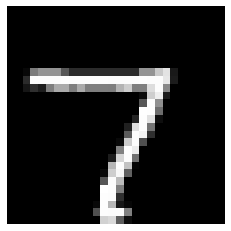

In [28]:
idx = np.random.randint(len(evaluation_labels))
pred = predict(evaluation_data[idx].reshape(-1, 1))
print(f'el valor predicho es: {pred}')
plt.imshow(test_image[idx].squeeze(), cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

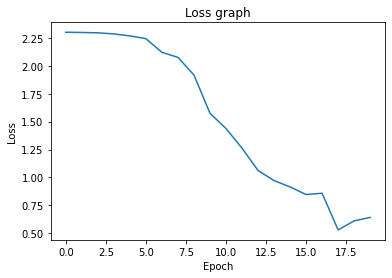

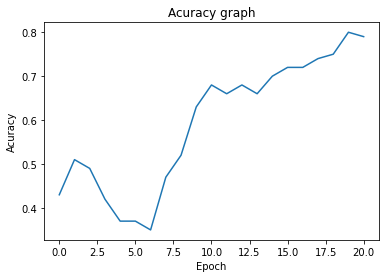

In [23]:
loss = [2.3015476826184456,2.299622848798562,2.296309293896111,
        2.2866383043632785,2.268758549340848,2.24407876962452,
        2.1215324148474513,2.076379892462489,1.918139013666352,
       1.5752199367829172,1.4383212278434965,1.2625913476040744,
       1.0619766866176423,0.9716318945735759,0.914867031777449,
       0.8462886275785624,0.8579647229636155,0.5290947799721492,
       0.6101627829002652,0.6413448053808056]
acc = [0.43,0.51,0.49,0.42,0.37,0.37,0.35,0.47,0.52,0.63,0.68,0.66,0.68,
      0.66,0.7,0.72,0.72,0.74,0.75,0.8,0.79]

plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss graph')
plt.show()

plt.plot(acc)
plt.xlabel('Epoch')
plt.ylabel('Acuracy')
plt.title('Acuracy graph')
plt.show()